In [1]:
import distiller 
import numpy as np
import os, collections
import bitstring 
import time 
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision 
import models 
from matplotlib import pyplot as plt
from eval_util import test_imagenet 
# import multiprocessing 
%matplotlib inline

print('using GPU:', torch.cuda.is_available())

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using GPU: True


In [2]:
# check the weight distribution of other pre-trained models in torch vision
# use resnet18, alexnet, vgg16 

pretrained_models = {'resnet18': torchvision.models.resnet18(pretrained=True),
                     'resnet34': torchvision.models.resnet34(pretrained=True),
                     'alexnet': torchvision.models.alexnet(pretrained=True),
                     'squeezenet': torchvision.models.squeezenet1_0(pretrained=True),
                     'vgg16':  torchvision.models.vgg16(pretrained=True), 
                      'vgg16_bn':  torchvision.models.vgg16_bn(pretrained=True), 
                     'densenet':  torchvision.models.densenet161(pretrained=True),
                     'inception_v3':  torchvision.models.inception_v3(pretrained=True),
                    }
# for model_name, pretrained_model in pretrained_models.items():
#     tensor = [param.data.cpu().numpy().ravel() for param in pretrained_model.parameters()]
#     tensor = np.concatenate(tensor)
#     minv, maxv = np.min(tensor), np.max(tensor)
#     num_values = tensor.shape[0]
#     plt.hist(tensor, bins=10000)
#     plt.title(model_name+ ':[%f, %f], #=%.1f(M)' %(minv, maxv, num_values/10e6))
#     plt.show()

model_name = 'alexnet'
model = pretrained_models[model_name]
print(model)

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [3]:
# print(acc1)

In [4]:
valdir = '/home/hguan2/datasets/imagenet/val'
acc1 = test_imagenet(model, valdir, num_batches=50)

Test: [  0/500]	Time  1.249 ( 1.249)	Loss 9.9806e-01 (9.9806e-01)	Acc@1  80.00 ( 80.00)	Acc@5  88.00 ( 88.00)
Test: [ 10/500]	Time  1.031 ( 1.116)	Loss 1.5428e+00 (1.1033e+00)	Acc@1  64.00 ( 74.09)	Acc@5  82.00 ( 89.00)
Test: [ 20/500]	Time  0.981 ( 1.125)	Loss 1.4201e+00 (1.3543e+00)	Acc@1  50.00 ( 68.19)	Acc@5  90.00 ( 86.43)
Test: [ 30/500]	Time  1.038 ( 1.108)	Loss 2.6921e+00 (1.5994e+00)	Acc@1  40.00 ( 62.74)	Acc@5  71.00 ( 83.39)
Test: [ 40/500]	Time  0.995 ( 1.103)	Loss 9.6465e-01 (1.6422e+00)	Acc@1  79.00 ( 61.51)	Acc@5  88.00 ( 82.98)
Acc@1: 64.860, Acc@5: 84.640


In [5]:
# post train quantization 
quantizer = distiller.quantization.PostTrainLinearQuantizer(model)
quantizer.prepare_model()
print(model)

AlexNet(
  (features): Sequential(
    (0): RangeLinearQuantParamLayerWrapper(
      mode=SYMMETRIC, num_bits_acts=8, num_bits_params=8, num_bits_accum=32, clip_acts=False, per_channel_wts=False
      preset_activation_stats=False
      w_scale=135.7703, w_zero_point=0.0000
      base_b_scale=45.2447, base_b_zero_point=0.0000
      (wrapped_module): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    )
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): RangeLinearQuantParamLayerWrapper(
      mode=SYMMETRIC, num_bits_acts=8, num_bits_params=8, num_bits_accum=32, clip_acts=False, per_channel_wts=False
      preset_activation_stats=False
      w_scale=57.0281, w_zero_point=0.0000
      base_b_scale=254.3297, base_b_zero_point=0.0000
      (wrapped_module): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, 

In [6]:
acc1 = test_imagenet(model, valdir, num_batches=50)

Test: [  0/500]	Time  1.229 ( 1.229)	Loss 1.0247e+00 (1.0247e+00)	Acc@1  81.00 ( 81.00)	Acc@5  88.00 ( 88.00)
Test: [ 10/500]	Time  0.999 ( 1.125)	Loss 1.5532e+00 (1.1451e+00)	Acc@1  67.00 ( 74.00)	Acc@5  84.00 ( 89.00)
Test: [ 20/500]	Time  0.979 ( 1.129)	Loss 1.4807e+00 (1.3883e+00)	Acc@1  53.00 ( 68.00)	Acc@5  90.00 ( 86.43)
Test: [ 30/500]	Time  1.033 ( 1.112)	Loss 2.6967e+00 (1.6292e+00)	Acc@1  39.00 ( 62.68)	Acc@5  72.00 ( 83.35)
Test: [ 40/500]	Time  0.966 ( 1.105)	Loss 1.0108e+00 (1.6735e+00)	Acc@1  77.00 ( 61.46)	Acc@5  87.00 ( 82.90)
Acc@1: 64.800, Acc@5: 84.580


In [6]:
# check the distribution of parameters 
# thr = 32
# layer_id = 0 
# for param_name, param in model.named_parameters():
#     if len(param.size()) < 2:
#         continue
#     counter = collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr)
#     tmp = sorted(counter.items(), key=lambda x: x[0])
#     values, counts = zip(*tmp)
#     percentages = [count/sum(list(counts)) for count in counts]
#     bar = plt.bar(values, percentages)
#     for rect in bar:
#         height = rect.get_height()
#         plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
# #     print(['%.2f' %(p) for p in percentages])
#     #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
#     plt.xticks(values, [str(int(v)*thr+thr) for v in values])
#     plt.title('layer_id:'+str(layer_id) + ', '+ str(tuple(param.size())))
# #     plt.grid()
#     plt.ylim(0, 1.1)
#     plt.show()
#     layer_id += 1

#weights: 21779648 , #params: 21797672 percentage: 0.999173


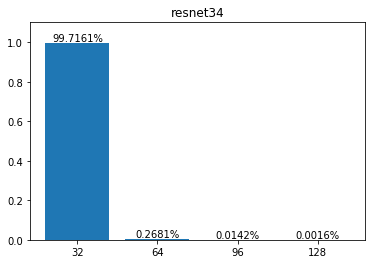

In [7]:
# check the distribution of parameters all weights
thr = 32
total_values, num_weights = 0, 0 
counter = collections.Counter()
for param_name, param in model.named_parameters():
    total_values += param.nelement()
    if len(param.size()) < 2:
        continue
    num_weights += param.nelement()
    counter.update(collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr + 1))
    
tmp = sorted(counter.items(), key=lambda x: x[0])
values, counts = zip(*tmp)
total_weights = sum(list(counts))

assert total_weights == num_weights
print('#weights:', total_weights, ', #params:', total_values, 'percentage:', '%.6f' %(num_weights/total_values))

percentages = [count/total_weights for count in counts]
bar = plt.bar(values, percentages)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
#     print(['%.2f' %(p) for p in percentages])
#plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
plt.xticks(values, [str(int(v)*thr) for v in values])
plt.title(model_name)
#     plt.grid()
plt.ylim(0, 1.1)
plt.show()
